### Example 13 - Detecting Market Making

In this example, we'll look for active market making activity in the most busy high security station
in New Eden.  We'll attempt to estimate the answers to two questions:

1. How many assets are subject to active market making?
2. How many players are trying to make a market in a given asset?

Answers to these questions will help us formulate our market making strategy, specifically:

1. Which asset types are most competitive? And...
2. How many players am I competing with?

We can check for market making by computing how frequently the bid or ask changes between snapshots for each asset.  An asset in which the bid or ask changes every snaphshot is very active and it's likely market making is going on.  Note, however, that there is no set frequency of change which defines market making.  Instead, we'll look at change frequency as it relates to other market features, such as whether market activity is clustered, or uniform throughout the day.

We can detect active market participants by looking for orders which change frequently.  Each such order is associated with at least one market participant, which will allow us to estimate an upper bound on the number of active participants.

Before we perform any analysis, we'll filter for liquid assets since these are the assets most likely to experience active market making.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
# EveKit imports
from evekit.reference import Client
from evekit.util import convert_raw_time

In [2]:
# As in previous examples, we'll consider opportunities in The Forge at the busiest station in Jita.
sde_client = Client.SDE.get()
region_query = "{values: ['The Forge']}"
station_query = "{values: ['Jita IV - Moon 4 - Caldari Navy Assembly Plant']}"
region_id = sde_client.Map.getRegions(regionName=region_query).result()[0][0]['regionID']
station_id = sde_client.Station.getStations(stationName=station_query).result()[0][0]['stationID']
compute_date = datetime.datetime(2017, 1, 10)
print("Using region_id=%d, station_id=%d at %s" % (region_id, station_id, str(compute_date)))

Using region_id=10000002, station_id=60003760 at 2017-01-10 00:00:00


In [3]:
# We'll start with all market types, then filter to just the liquid types.
#
market_types = Client.SDE.load_complete(sde_client.Inventory.getTypes, marketGroupID="{start: 0, end: 1000000000}")
market_type_map = {}
for x in market_types:
    market_type_map[x['typeID']] = x
len(market_types)

11748

In [4]:
# We'll filter for liquid assets over the previous thirty days before our target date.
# This will require 30 days of history.  We exclude our target date from the history list.
#
from evekit.marketdata import MarketHistory
date_range = pd.date_range(compute_date - datetime.timedelta(days=30), compute_date - datetime.timedelta(days=1))
market_history = MarketHistory.get_data_frame(dates=date_range, types=market_type_map.keys(), regions=[region_id], 
                                              config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2016-12-11 00:00:00...done
Retrieving 2016-12-12 00:00:00...done
Retrieving 2016-12-13 00:00:00...done
Retrieving 2016-12-14 00:00:00...done
Retrieving 2016-12-15 00:00:00...done
Retrieving 2016-12-16 00:00:00...done
Retrieving 2016-12-17 00:00:00...done
Retrieving 2016-12-18 00:00:00...done
Retrieving 2016-12-19 00:00:00...done
Retrieving 2016-12-20 00:00:00...done
Retrieving 2016-12-21 00:00:00...done
Retrieving 2016-12-22 00:00:00...done
Retrieving 2016-12-23 00:00:00...done
Retrieving 2016-12-24 00:00:00...done
Retrieving 2016-12-25 00:00:00...done
Retrieving 2016-12-26 00:00:00...done
Retrieving 2016-12-27 00:00:00...done
Retrieving 2016-12-28 00:00:00...done
Retrieving 2016-12-29 00:00:00...done
Retrieving 2016-12-30 00:00:00...done
Retrieving 2016-12-31 00:00:00...done
Retrieving 2017-01-01 00:00:00...done
Retrieving 2017-01-02 00:00:00...done
Retrieving 2017-01-03 00:00:00...done
Retrieving 2017-01-04 00:00:00...done
Retrieving 2017-01-05 00:00:00...done
Retrieving 2

In [5]:
# Include the liquidity filter framework from previous examples.
#
def liquid_types(history, liquidp, verbose=False):
    # Result is a map from region to set of liquid types for that region
    # Iterate through all types contained in the history object
    liquid_map = {}
    count = 0
    # Iterate through all regions and types
    for next_region in history.region_id.unique():
        liquid_set = set()
        by_region = history[history.region_id == next_region]
        for next_type in by_region.type_id.unique():
            by_type = by_region[by_region.type_id == next_type]
            if liquidp(next_region, next_type, by_type):
                liquid_set.add(next_type)
            count += 1
            if count % 1000 == 0 and verbose:
                print("Tested %d (region, type) pairs" % count)
        liquid_map[next_region] = liquid_set
    return liquid_map

In [6]:
# In this example, we'll filter for assets which trade almost every
# day in our historic range, and which have a reasonable number
# of orders (NOT volume!).
#
def liquidity_filter(min_days, min_count):
    def liquidp(region_id, type_id, history):
        return len(history) >= min_days and \
               len(history[history.order_count < min_count]) == 0
    return liquidp

In [7]:
# We'll use the following values to parameterize the liquidity filter
#
# Minimum number of orders per day
min_count = 500
# Each type we consider must have at least this many days worth of history
min_values = len(market_history.index.unique()) - 2

In [8]:
# Now compute liquid types.  The liquidity filter returns a map from region to the
# set of liquid types in that region.
#
liquid_type_map = liquid_types(market_history, liquidity_filter(min_values, min_count))
len(liquid_type_map[region_id])

103

In [9]:
# Finally, we're ready to start looking for active market making on our target date.  To do that,
# we'll need a day of order book data for our liquid types.  Depending on how you set your
# liquidity filter, this cell may take a while to execute.
#
from evekit.marketdata import OrderBook
order_book = OrderBook.get_data_frame(dates=[compute_date], types=liquid_type_map[region_id], regions=[region_id], 
                                      config=dict(local_storage=".", tree=True, skip_missing=True, verbose=True))

Retrieving 2017-01-10 00:00:00...done


In [10]:
# Since we're only concerned about orders at our target station, we can filter by location_id
order_book_local = order_book[order_book.location_id == station_id]

In [11]:
# Now we're ready to check for changes to the best bid or ask.  We consider a change to have occurred
# if one of two things happens:
#
# 1. The order ID of the best bid or ask has changed; or,
# 2. The price of the best bid or ask has changed.
#
# Regardless, we now require functions which will return the best bid or ask given
# an order book snapshot.
#

# Return best ask from an order book snapshot.
# Returns an order row or None if no current best ask exists.
#
def get_best_ask(snapshot):
    asks = snapshot[snapshot.buy == False]
    if len(asks) > 0:
        return [next_order[1] for next_order in asks.iterrows()][0]
    return None

# Return best bid from an order book snapshot.
# Return an order row or None if no current best bid exists.
#
def get_best_bid(snapshot):
    bids = snapshot[snapshot.buy == True]
    if len(bids) > 0:
        return [next_order[1] for next_order in bids.iterrows()][0]
    return None

# Given two orders, this function returns true if the order IDs are 
# different, or if the prices are different, and False otherwise.
#
def check_order_changed(order_1, order_2):
    if order_1 is None and order_2 is None:
        return False
    if order_1 is None or order_2 is None:
        return True
    return order_1['order_id'] != order_2['order_id'] or order_1['price'] != order_2['price']


In [12]:
# The following function checks for best bid or ask changes for each snapshot 
# of an order book over the desired types.  The result is a Pandas DataFrame
# indexed by snapshot time and containing the columns:
#
# time - the time when a bid or ask changed
# type_id - type ID which changed
#
def find_active_markets(order_book, type_list, verbose=False):
    total_snapshots = len(order_book.groupby(order_book.index))
    changes = []
    if verbose:
        print("Checking %d snapshots for market making" % total_snapshots, flush=True)    
    count = 0
    #
    # Map from type to previous bid or ask
    prev_bid = {}
    prev_ask = {}
    for next_type in type_list:
        prev_bid[next_type] = None
        prev_ask[next_type] = None
    #
    for snapshot_group in order_book.groupby(order_book.index):
        #
        # Each group is a pair (snapshot_time, snapshot_dataframe)
        snapshot_time = snapshot_group[0]
        snapshot = snapshot_group[1]
        if verbose:
            print("X", end='', flush=True)
            count += 1
            if count % 72 == 0:
                print()
        #
        # Iterate through each type in the type list
        for next_type in type_list:
            by_type = snapshot[snapshot.type_id == next_type]
            p_ask = prev_ask[next_type]
            p_bid = prev_bid[next_type]
            c_ask = get_best_ask(by_type)
            c_bid = get_best_bid(by_type)
            if check_order_changed(p_bid, c_bid) or check_order_changed(p_ask, c_ask):
                changes.append(dict(time=snapshot_time, type_id=next_type))
            prev_ask[next_type] = c_ask
            prev_bid[next_type] = c_bid
    if verbose:
        print(flush=True)
    return pd.DataFrame(changes, index=[x['time'] for x in changes])

In [13]:
# Compute bid/ask changes between snapshots.  Once we have this data we can compute how 
# frequently the bid/ask changes for each asset type.
#
active_data = find_active_markets(order_book_local, liquid_type_map[region_id], verbose=True)

Checking 288 snapshots for market making
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



In [14]:
# We now have a DataFrame with a row for a type each time the bid or ask changes.
# One simple way to look for active markets is to just count how many times the 
# bid or ask changes.  We can then sort in descending order to find the most active
# asset types.
#
print("%7s  %7s  %s" % ("type ID", "Count", "Type Name"))
for x in active_data.groupby(active_data.type_id).count().sort_values(by='time', ascending=False).iterrows():
    print("%7d  %7d  %s" % (x[0], x[1], market_type_map[x[0]]['typeName']))

type ID    Count  Type Name
  11370      199  Prototype Cloaking Device I
  40520      187  Skill Injector
  35658      184  5MN Quad LiF Restrained Microwarpdrive
   5973      178  5MN Y-T8 Compact Microwarpdrive
  29668      176  30 Day Pilot's License Extension (PLEX)
  31790      174  Medium Core Defense Field Extender I
  25618      172  Micro Circuit
  22291      170  Ballistic Control System II
   8517      170  Medium F-S9 Regolith Compact Shield Extender
   5839      167  IFFA Compact Damage Control
    519      166  Gyrostabilizer II
  21815      164  Elite Drone AI
    527      163  Stasis Webifier II
  25619      163  Logic Circuit
   2281      161  Adaptive Invulnerability Field II
  25598      155  Tripped Power Circuit
  34203      155  Augmentation Decryptor
   3831      152  Medium Shield Extender II
  25600      149  Burned Logic Circuit
     39      148  Zydrine
  11269      147  Energized Adaptive Nano Membrane II
     36      147  Mexallon
  25590      145  Contami

You may recall there are 288 order book snapshots in a day.  None of the assets we analyzed has a change count equal to this value, so we know none of these assets change every snapshot.  However, there are 23 assets which changed more than 144 times, or once every other snapshot (on average).  There are almost certainly active market makers trading on these assets.

An asset which changes more than 48 times is, on average, changing every 30 minutes.  All but 13 of our asset list meet this criteria.  However, as we lower the change frequency, it becomes more likely that changes may be grouped together over a smaller time period.  There are at least two ways we can improve our intuition around the spacing of changes for an asset:

1. We can plot the times when changes occurred; and,
2. We can look for clusters in the data showing times when there were frequent changes.

(736339.0, 736339.9965277778)

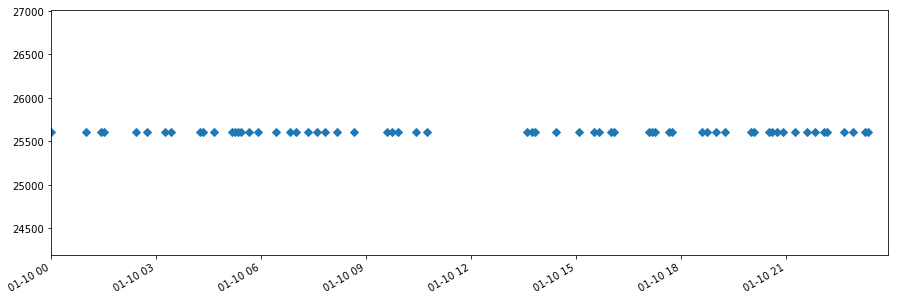

In [15]:
# Plotting the time when changes occurred is straightforward.  Here's a plot of changes for 
# "Conductive Polymer" which changed 63 times on our sample day:
#
ax = active_data[active_data.type_id == 25604].plot(style="D", figsize=[15,5], legend=False)
ax.set_xlim(datetime.datetime(2017,1,10,0,0,0), datetime.datetime(2017,1,10,23,55,0))

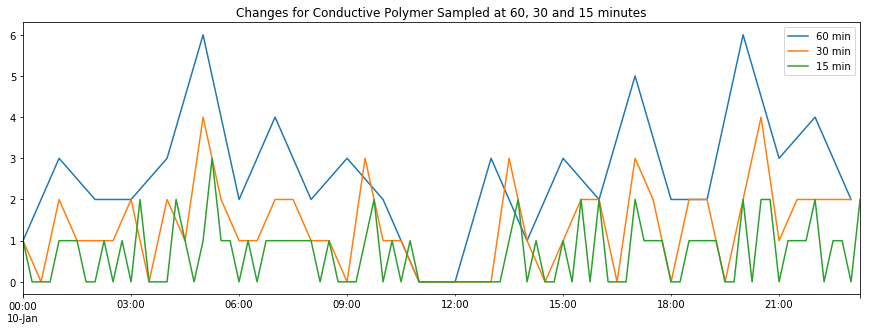

In [16]:
# From the plot, the data has an obvious gap of about two hours at mid day.
# There also appear to be clusters of trades in a few locations.  One way to view 
# clustering is to resample the data and count the number of occurrences in each 
# interval.  This is also a way to determine the most active times of day for a 
# given asset.
#
# Here's a view of "Conductive Polymer" with different re-sampling intervials
#
title = "Changes for Conductive Polymer Sampled at 60, 30 and 15 minutes"
ax = active_data[active_data.type_id == 25604].resample('60Min').count().type_id.plot(figsize=[15,5], legend=True, title=title)
active_data[active_data.type_id == 25604].resample('30Min').count().type_id.plot(ax=ax, legend=True)
active_data[active_data.type_id == 25604].resample('15Min').count().type_id.plot(ax=ax, legend=True)
L=ax.legend()
L.get_texts()[0].set_text('60 min')
L.get_texts()[1].set_text('30 min')
L.get_texts()[2].set_text('15 min')

The 15 minute resampled data shows the mid day gap very clearly.  Conversely, the 60 minute sampled data shows the most active times of day \(at about 05:00, 17:00 and 20:00\).  As you might expect, active times are most relevant for less active instruments.  Very active assets show no real gaps.  For example, the plot below shows the change times for "Prototype Cloaking Device I", the most active asset on our list.

(736339.0, 736339.9965277778)

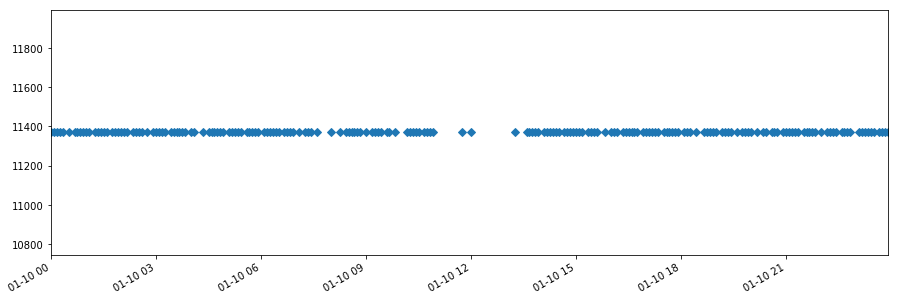

In [17]:
# Active times for "Prototype Cloaking Device I", the most active asset on our sample day.
#
ax = active_data[active_data.type_id == 11370].plot(style="D", figsize=[15,5], legend=False)
ax.set_xlim(datetime.datetime(2017,1,10,0,0,0), datetime.datetime(2017,1,10,23,55,0))

Astute readers may have noticed that both Conductive Polymers and Prototype Cloaking Devices show a very similar gap around 12:00 UTC.  This time range corresponds to daily downtime for EVE when no trading can occur.  Although down time is typically less than 30 minutes, trading on most assets consistently lags around this time.

Now that we've identified likely market making candidates, let us turn to estimating how many players are actively making a market for a given asset.

In [18]:
# One way to identify an active market maker is to look for an order which changes frequently
# throughout the day.  Such orders will have the same order ID, but will change price one or
# more times a day as the owning player attempts to capture the best bid or ask.
#
# If we simply counted the number of orders which change throughout the day, we'd likely have
# an overestimation of the number of active market participants because different players may
# participate at different times of the day.  Instead, we'll re-sample the order book over a 
# configurable interval and tabulate the number of orders which change in a given interval.
# This is still an estimate because some market participants may change their orders less
# frequently than our re-sampling interval.  However, results should be reasonable given a
# sufficiently large re-sampling interval.
#
# The following function counts the number of orders which have changed price in a given
# interval.  The result is a Pandas DataFrame indexed by start snapshot time and containing 
# the columns:
#
# time - the time when one or more orders changed
# type_id - type ID which changed
# change_count - the number of orders which changed
#
def count_order_changes(order_book, type_list, sample_interval, verbose=False):
    samples = order_book.resample(sample_interval)
    total_samples = len(samples)
    changes = []
    if verbose:
        print("Checking %d samples for market participants" % total_samples, flush=True)    
    count = 0
    #
    for sample_group in samples:
        #
        # Each group is a pair (sample_time, sample_dataframe)
        sample_time = sample_group[0]
        sample = sample_group[1]
        if verbose:
            print("X", end='', flush=True)
            count += 1
            if count % 72 == 0:
                print()
        #
        # Iterate through each type in the type list
        for next_type in type_list:
            # Reduce this sample by type
            by_type = sample[sample.type_id == next_type]
            # Group by orders
            orders = by_type.groupby(['order_id'])
            # Count the unique prices for each order, flag those orders with more than
            # one price in the samnple interval.
            changed = orders['price'].nunique() > 1
            # Count how many orders changed price at least once in the sample interval.
            count = changed[changed == True].count()
            # Save the number of orders which changed prices
            changes.append(dict(time=sample_time, type_id=next_type, change_count=count))
    if verbose:
        print(flush=True)
    return pd.DataFrame(changes, index=[x['time'] for x in changes])

In [19]:
# Now we're ready to compute market participants for each type.  For this first run, we'll
# resample over 1 hour intervals.
#
order_change_data = count_order_changes(order_book_local, liquid_type_map[region_id], '60Min', verbose=True)

Checking 24 samples for market participants
XXXXXXXXXXXXXXXXXXXXXXXX


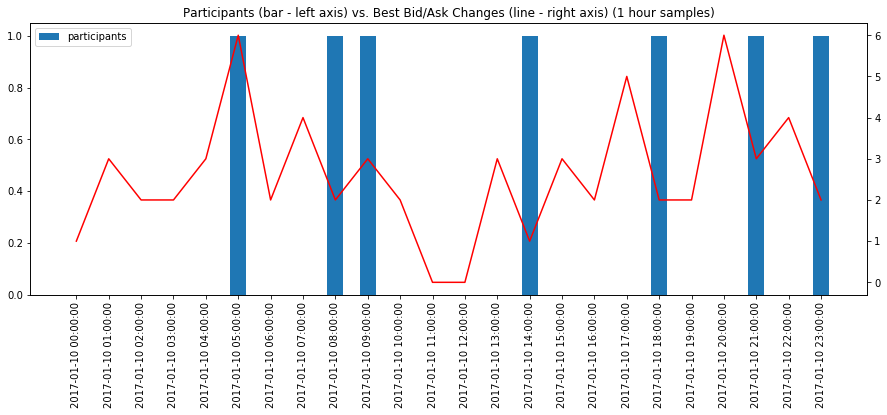

In [20]:
# The counts for each type indicate the number of distinct orders which changed price in the
# given time interval.  This is a rough approximation of the maximum number of market participants
# in that interval.  It's an approximation because a single player could be maintaining multiple 
# orders, causing us to overcount.  Also, we miss the first time a new particpant joins unless they
# happen to change their order within the resampling period.
#
# Let's see what the participant count looks like for "Conductive Polymer".
# We'll overlay our market participant data with the change count data we computed above,
# resampled to the same interval we used for market participants.
#
fig = plt.figure(figsize=[15,5])
title = "Participants (bar - left axis) vs. Best Bid/Ask Changes (line - right axis) (1 hour samples)"
ax = order_change_data[order_change_data.type_id == 25604].change_count.plot(kind='bar', legend=True, title=title)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), active_data[active_data.type_id == 25604].resample('60Min').count().type_id, color='r')
ax.legend().get_texts()[0].set_text('participants')

The peaks in the graphs do not quite line up and the sampled participant count is quite low.  One conclusion we might draw from this data is that market making is not really happening for Conductive Polymer.  Another possible conclusion is that the change cycle is much slower than one hour.  We can check out intuition by resampling for a larger change interval.

Checking 12 samples for market participants
XXXXXXXXXXXX


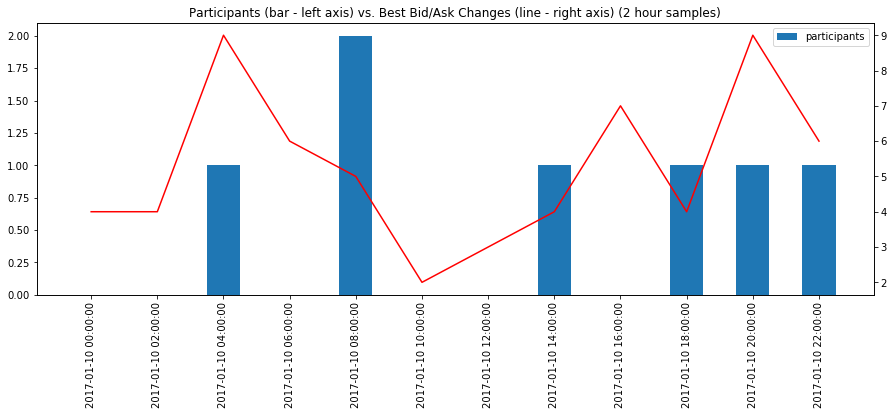

In [21]:
# First resample market participant data
#
order_change_data_2hour = count_order_changes(order_book_local, liquid_type_map[region_id], '120Min', verbose=True)
#
# Then plot the new data
#
fig = plt.figure(figsize=[15,5])
title = "Participants (bar - left axis) vs. Best Bid/Ask Changes (line - right axis) (2 hour samples)"
ax = order_change_data_2hour[order_change_data_2hour.type_id == 25604].change_count.plot(kind='bar', legend=True, title=title)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), active_data[active_data.type_id == 25604].resample('120Min').count().type_id, color='r')
ax.legend().get_texts()[0].set_text('participants')

Changing the sample interval has not captured more market participants which reinforces the hypothesis that market making is probably not occuring on this asset.  Instead, this could be one large order competing with a regular flow of small orders placed by casual players throughout the day.  The owner of the large order must regularly re-position to capture the best bid or ask.  We can confirm our hypothesis by looking more carefully at the order book snapshots for the day.  We leave that task as an exercise for the reader.

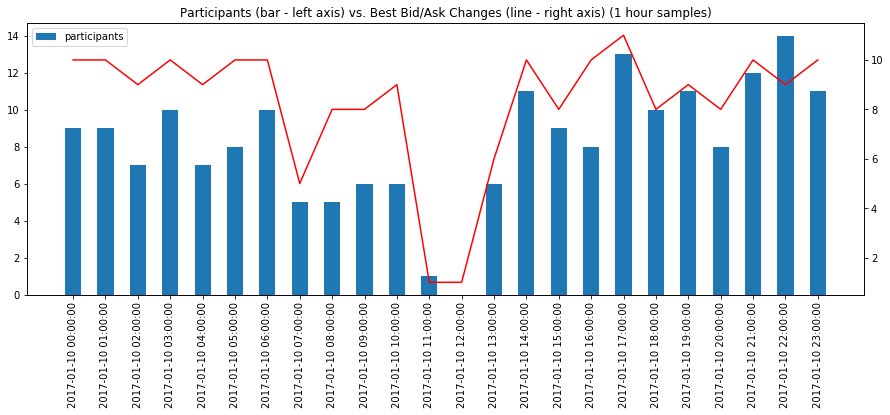

In [22]:
# Now let's look at the same plot for "Prototype Cloaking Device I", the most active asset on our sample day.
fig = plt.figure(figsize=[15,5])
title = "Participants (bar - left axis) vs. Best Bid/Ask Changes (line - right axis) (1 hour samples)"
ax = order_change_data[order_change_data.type_id == 11370].change_count.plot(kind='bar', legend=True, title=title)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), active_data[active_data.type_id == 11370].resample('60Min').count().type_id, color='r')
ax.legend().get_texts()[0].set_text('participants')

In [23]:
# From this plot, we see that there may be as many as 14 active market participants in a given hour 
# of trading for this asset.  That's a lot of competition!  If we decide to trade this asset, we likely
# won't be successful if we plan on updating our prices once an hour.  Let's change the sample frequency
# to see what things look like at 30 minute interval.
#
order_change_data_30min = count_order_changes(order_book_local, liquid_type_map[region_id], '30Min', verbose=True)

Checking 48 samples for market participants
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


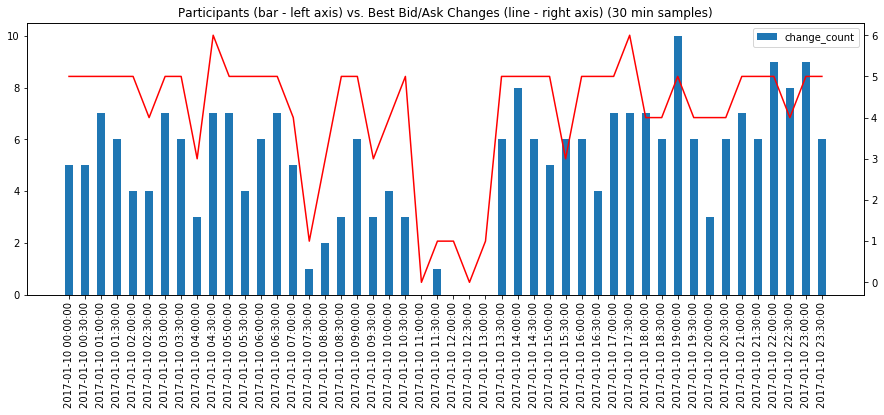

In [24]:
# And now the same graph again for comparison
fig = plt.figure(figsize=[15,5])
title = "Participants (bar - left axis) vs. Best Bid/Ask Changes (line - right axis) (30 min samples)"
ax = order_change_data_30min[order_change_data_30min.type_id == 11370].change_count.plot(kind='bar', legend=True, title=title)
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(), active_data[active_data.type_id == 11370].resample('30Min').count().type_id, color='r')

The number of participants per interval has gone down by 30-50% in most cases, but is still quite large in some intervals.  It seems unlikely that you'll get away with updating your orders once every 30 minutes in this asset type.  If you want to trade this asset successfully, you'll likely need to be watching it all day (more on this later).

In this example, we've built a simple filter for finding asset types for which markets are likely being made.  We've also created a simple technique to estimate the number of participants making a market in a given type.  However, for simplicity, we've restricted our analysis to a single day, so the usual caveats apply.  A more proper analysis would consider active assets over a larger time range.  We'll discuss back testing later in this chapter.